# EDA for Items
A deeper dive into the items data

In [ ]:
from config import proj
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import pyspark.sql.functions as sf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
items = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("items.parquet")))
items.show(5)
items = items.toPandas()

+--------+------------+-----+----------+
|item_nbr|      family|class|perishable|
+--------+------------+-----+----------+
|   96995|   GROCERY I| 1093|         0|
|   99197|   GROCERY I| 1067|         0|
|  103501|    CLEANING| 3008|         0|
|  103520|   GROCERY I| 1028|         0|
|  103665|BREAD/BAKERY| 2712|         1|
+--------+------------+-----+----------+
only showing top 5 rows



### Family and class counts

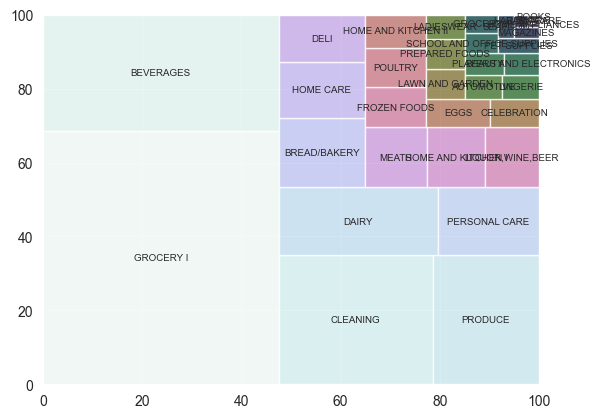

In [3]:
item_fam = items.family.value_counts()
squarify.plot(sizes=item_fam,
              label=item_fam.index,
              alpha=.8,
              color=sns.color_palette('cubehelix_r', 33),
              text_kwargs={'fontsize':7})
plt.show()

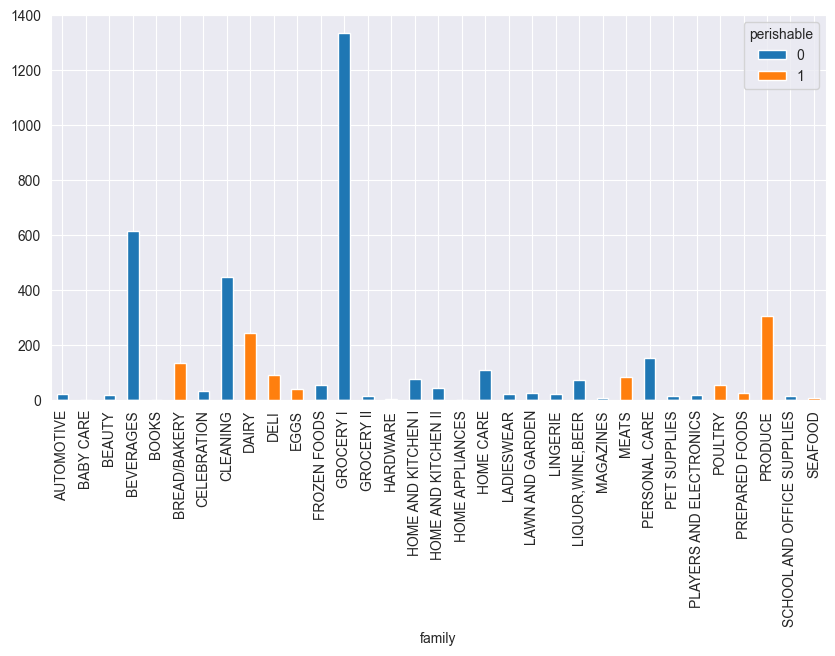

In [4]:
# Create dataset for stacked plot
it_fam_per = items.groupby(["family", "perishable"]).size()
it_fam_per = it_fam_per.unstack()

# plot
it_fam_per.plot(kind="bar", stacked=True, figsize=(10,5))
plt.show()

- Grocery 1 dominates in terms of range
- Can see that perishable is dependent on family

Perishable families below

In [5]:
list(items.query("perishable == 1")["family"].unique())

['BREAD/BAKERY',
 'DELI',
 'POULTRY',
 'EGGS',
 'DAIRY',
 'MEATS',
 'SEAFOOD',
 'PREPARED FOODS',
 'PRODUCE']

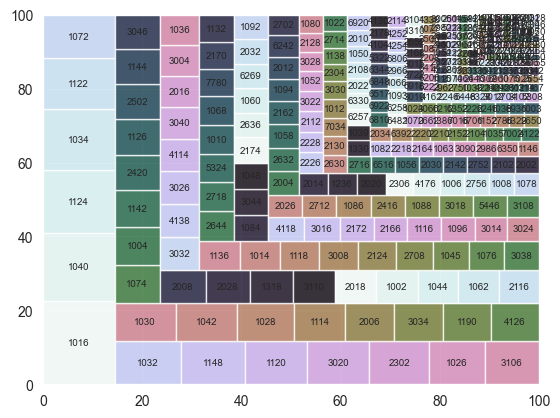

In [6]:
item_cls = items["class"].value_counts()
squarify.plot(sizes=item_cls,
              label=item_cls.index,
              alpha=.8,
              color=sns.color_palette('cubehelix_r', 33),
              text_kwargs={'fontsize':7})
plt.show()

Many classes for items, classes are all sorts of sizes ranging from large to small and everything inbetween

### Top selling items and families

In [7]:
# Load feature store
pfs = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("feature_store.parquet")))

In [24]:
# Roll up by total daily sales, then find the average daily sales across all stores and dates
avg_daily_sales = pfs\
    .groupby("item_nbr", "family" ,"date", "class")\
    .agg(sf.sum("unit_sales").alias("daily_sales"))\
    .groupby("item_nbr", "family", "class")\
    .agg(sf.sum("daily_sales").alias("avg_daily_sales"))

In [27]:
# Top 10 items
avg_daily_sales.toPandas().sort_values("avg_daily_sales", ascending=False).round(2)[1:10]

,item_nbr,family,class,avg_daily_sales
3108,1473474,PRODUCE,2014,3515910.73
390,1463992,BEVERAGES,1144,3095160.00
3525,1430040,BEVERAGES,1120,2539101.00
2921,1047679,BEVERAGES,1120,2529627.00
1579,1463993,BEVERAGES,1144,2523503.00
2651,819932,BEVERAGES,1122,2155529.00
3277,265559,GROCERY I,1072,1915834.00
1788,1167614,EGGS,2502,1872334.00
920,1642399,PRODUCE,2028,1821961.34


Beverages have a high daily sales

In [38]:
avg_daily_family_sales = pfs\
    .groupby("family" ,"date")\
    .agg(sf.sum("unit_sales").alias("daily_sales"))\
    .groupby("family")\
    .agg(sf.sum("daily_sales").alias("avg_daily_sales"))\
    .toPandas()

avg_daily_family_sales.sort_values("avg_daily_sales", ascending=False).round(0)

,family,avg_daily_sales
4,GROCERY I,175449088.0
8,BEVERAGES,129863716.0
6,PRODUCE,90462457.0
26,CLEANING,46886737.0
15,DAIRY,34369753.0
10,BREAD/BAKERY,20846124.0
22,POULTRY,15379501.0
32,MEATS,14133581.0
25,PERSONAL CARE,12478258.0
20,DELI,11858868.0


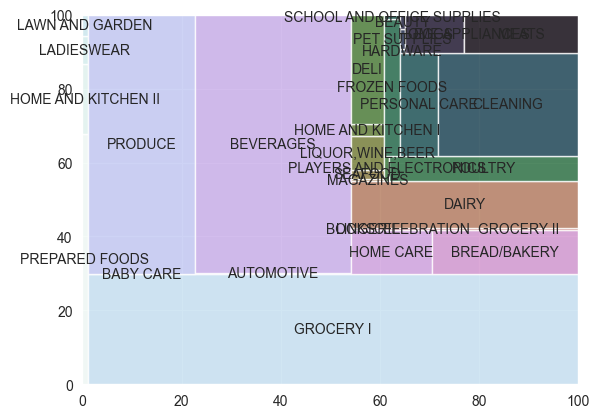

In [34]:
# Visualisation of families by average daily unit sales
squarify.plot(sizes=avg_daily_family_sales["avg_daily_sales"],
              label=avg_daily_family_sales["family"],
              alpha=.8,
              color=sns.color_palette('cubehelix_r', 33),
              text_kwargs={'fontsize':10})
plt.show()

- Grocery, beverages and produce are the big high unit sale families
- Books, baby care and home appliances are the lower ones